In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# 1. Muat Dataset dan Pra-pemrosesan Awal
file_path = "voice.csv"
df = pd.read_csv(file_path)

print("--- Informasi Dataset Awal ---")
df.info()
print("\nDistribusi kelas (label):\n", df['label'].value_counts())
print("-" * 40)

# a. Encoding label (male/female) menjadi angka (0/1)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label']) # female=0, male=1

# Pisahkan fitur (X) dan target (y)
X = df.drop('label', axis=1)
y = df['label']

print("\nDataset berhasil dimuat dan label telah di-encode (female=0, male=1).")

--- Informasi Dataset Awal ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20 

In [3]:
# 2. Standardisasi Fitur dan Pembagian Data

# Standardisasi Fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Pisahkan data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("--- Pembagian dan Standardisasi Data ---")
print(f"Data Training (70%): {X_train.shape[0]} baris")
print(f"Data Testing (30%): {X_test.shape[0]} baris")

--- Pembagian dan Standardisasi Data ---
Data Training (70%): 2217 baris
Data Testing (30%): 951 baris


In [4]:
# 3. Pemilihan Fitur Optimal (Soal No. 2)

# Menggunakan SelectKBest untuk 10 fitur terbaik
num_features = 10
selector = SelectKBest(f_classif, k=num_features)
selector.fit(X_train, y_train)
selected_features_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_features_indices].tolist()

print(f"--- Fitur Optimal yang Digunakan ({num_features} fitur) ---")
print(selected_features)
print("\nAlasan: Fitur-fitur ini memiliki korelasi tertinggi dengan label, diukur dengan uji F (ANOVA).")

# Ambil subset fitur terbaik untuk data train dan test
X_test_best = X_test[selected_features]
X_train_best = X_train[selected_features]

--- Fitur Optimal yang Digunakan (10 fitur) ---
['meanfreq', 'sd', 'median', 'Q25', 'IQR', 'sp.ent', 'sfm', 'centroid', 'meanfun', 'mindom']

Alasan: Fitur-fitur ini memiliki korelasi tertinggi dengan label, diukur dengan uji F (ANOVA).


In [5]:
# 4. Mencari Nilai k Terbaik (Soal No. 3)

# Mencoba nilai k dari 1 sampai 20
k_values = range(1, 21)
cv_scores = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    # Menghitung Rata-rata Cross-Validation Score pada data training
    scores = cross_val_score(knn, X_train_best, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

    # Menghitung Test Accuracy
    knn.fit(X_train_best, y_train)
    y_pred = knn.predict(X_test_best)
    test_accuracies.append(accuracy_score(y_test, y_pred))

# Cari nilai k dengan CV Score tertinggi
best_k_cv_index = np.argmax(cv_scores)
best_k_cv = k_values[best_k_cv_index]
best_score_cv = cv_scores[best_k_cv_index]

print("--- Hasil Analisis Nilai k ---")
print(f"Nilai k terbaik (berdasarkan 5-fold CV) adalah: k = {best_k_cv}")
print(f"Rata-rata Akurasi CV tertinggi: {best_score_cv:.4f}")

--- Hasil Analisis Nilai k ---
Nilai k terbaik (berdasarkan 5-fold CV) adalah: k = 4
Rata-rata Akurasi CV tertinggi: 0.9738


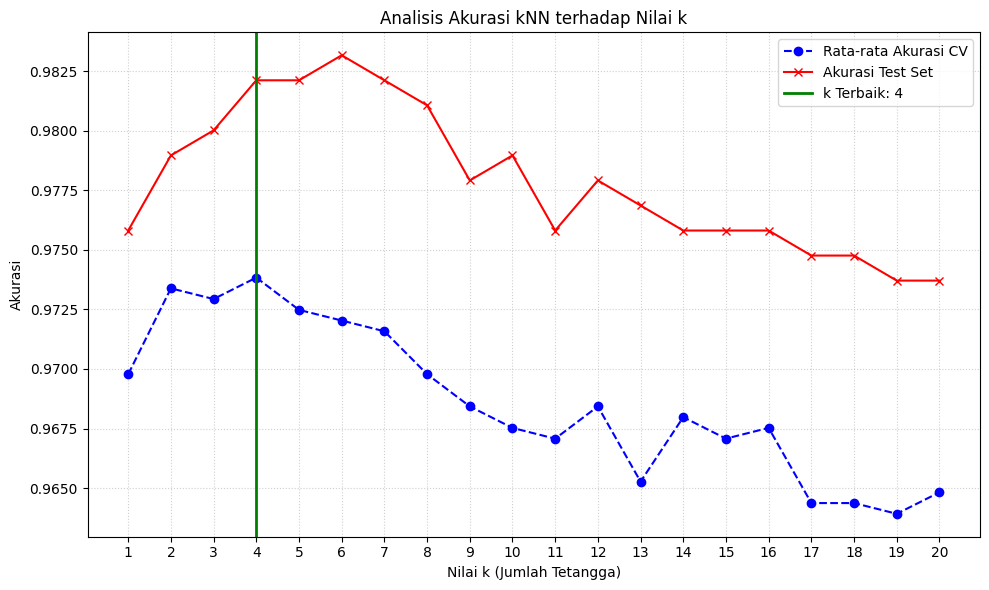

In [6]:
# 5. Visualisasi Hasil Analisis (Soal No. 3)

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='--', color='blue', label='Rata-rata Akurasi CV')
plt.plot(k_values, test_accuracies, marker='x', linestyle='-', color='red', label='Akurasi Test Set')

plt.title('Analisis Akurasi kNN terhadap Nilai k')
plt.xlabel('Nilai k (Jumlah Tetangga)')
plt.ylabel('Akurasi')
plt.xticks(k_values)
plt.grid(True, linestyle=':', alpha=0.6)
plt.axvline(x=best_k_cv, color='green', linestyle='-', label=f'k Terbaik: {best_k_cv}', linewidth=2)
plt.legend()
plt.tight_layout()
plt.savefig('knn_k_analysis_plot.png')
plt.show() # Tidak muncul, namun file gambar disimpan

In [7]:
# 6. Evaluasi Model Akhir

# Inisialisasi LabelEncoder lagi untuk mendapatkan nama kelas asli
le_final = LabelEncoder()
# Untuk memastikan urutan 'female', 'male'
le_final.fit(pd.read_csv('voice.csv')['label'])

knn_best = KNeighborsClassifier(n_neighbors=best_k_cv)
knn_best.fit(X_train_best, y_train)
y_pred_final = knn_best.predict(X_test_best)
accuracy_final = accuracy_score(y_test, y_pred_final)

print("--- Evaluasi Model Akhir ---")
print(f"Akurasi Test Set Akhir: {accuracy_final:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_final, target_names=le_final.classes_))

--- Evaluasi Model Akhir ---
Akurasi Test Set Akhir: 0.9821

Classification Report:
               precision    recall  f1-score   support

      female       0.98      0.99      0.98       476
        male       0.99      0.98      0.98       475

    accuracy                           0.98       951
   macro avg       0.98      0.98      0.98       951
weighted avg       0.98      0.98      0.98       951

